In [1]:
#!/usr/bin/env python3

import glob
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
from dataset_utils import MoNuSegDataset
from model import CNN3
from PIL import Image 
from eval_train import compute_AJI
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import cv2

In [2]:
train = False
ROOT = '/share/DEEPLEARNING/datasets/monuseg/'
TRAIN_IMG = join(ROOT,'MoNuSegTrainingData')
TEST_IMG = join(ROOT,'MoNuSegTestData')
if train:
    IMGS_DIR = join(TRAIN_IMG,'Tissue_Images')
    MASKS_DIR = join(TRAIN_IMG,'Binary_masks')
    OUTPUT_DIR = join(TRAIN_IMG,'Output')
else:
    IMGS_DIR = join(TEST_IMG,'Tissue_Images')
    MASKS_DIR = join(TEST_IMG,'Binary_masks')
    OUTPUT_DIR = join(TEST_IMG,'Output')


In [3]:
#MODEL_DIR = '/share/homes/karmimy/equiv/save_model/fully_supervised_monuseg/52'
MODEL_DIR = '/share/homes/karmimy/equiv/save_model/rot_equiv_monuseg/3'
#MODEL_NAME = 'fully_supervised_monuseg.pt'
MODEL_NAME = 'rot_equiv_monuseg.pt'
gpu = 1

In [4]:
test_dataset = MoNuSegDataset(ROOT,image_set='test',load_entire_image=True,binary=False)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=4,pin_memory=True,\
            batch_size=1)
device =  torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")

In [5]:
model = torch.load(join(MODEL_DIR,MODEL_NAME))
model.to(device)

 )
    )
    (layer2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(12

In [6]:
i,m = test_dataset.__getitem__(0)


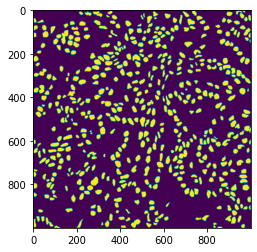

In [7]:
plt.imshow(np.where(m>1,1,m))

In [8]:
aji,aji_mean = compute_AJI(model,dataloader_val,device,dist_factor=0.3,threshold=54,clean_prediction=False,it_bg=0,it_opening=0)

In [9]:
aji

[0.5160798246077447,
 0.5521864967024624,
 0.6099229638810741,
 0.5981409323505938,
 0.5643317702227433,
 0.6245483562598227,
 0.5441671230733119,
 0.5425609232013752,
 0.6574278555199287,
 0.6185699916415204,
 0.6106255674298028,
 0.5562929184961897,
 0.6483915643463728,
 0.6683237070249485]

In [10]:
aji_mean

0.5936835710541349

In [8]:
iou = state.metrics['IoU']
miou = state.metrics['mean IoU']
acc = state.metrics['accuracy']
loss = state.metrics['CE Loss'] 
dice_coeff = state.metrics['dice_coeff']
precision = state.metrics['precision']
recall = state.metrics['recall']

In [10]:
iou.mean()

tensor(0.7963, dtype=torch.float64)

In [6]:
i,m = test_dataset.__getitem__(0)

In [7]:
pred = model(i.unsqueeze(0).to(device))

In [8]:
pred = pred['out'].squeeze()

In [9]:
pred.size()

torch.Size([2, 1000, 1000])

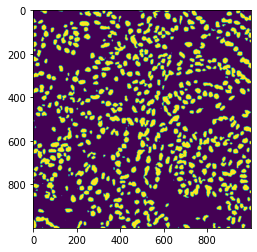

In [10]:
plt.imshow(pred.argmax(dim=0).detach().cpu().numpy())

In [7]:
i,m = test_dataset.__getitem__(0)


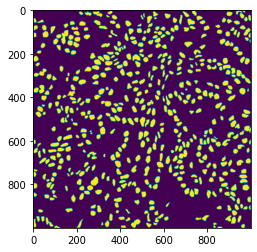

In [9]:
m = np.where(m>1,1,m)
plt.imshow(m)

In [ ]:
np.

In [20]:
pred_np = pred.argmax(dim=0).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


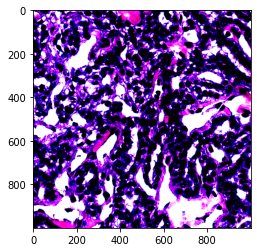

In [15]:
plt.imshow(i.transpose_(0,2).transpose_(0,1))

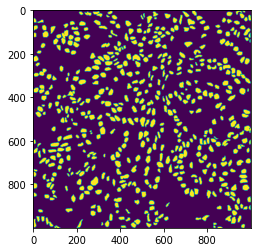

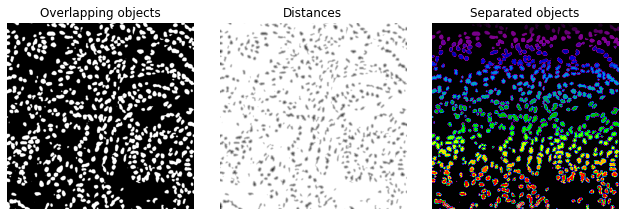

In [21]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(pred_np)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=pred_np)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=pred_np)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(pred_np, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


In [22]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [23]:
np.unique(labels)

array([   0,    1,    2, ..., 1645, 1646, 1647], dtype=int32)

In [27]:
m = np.array(m)

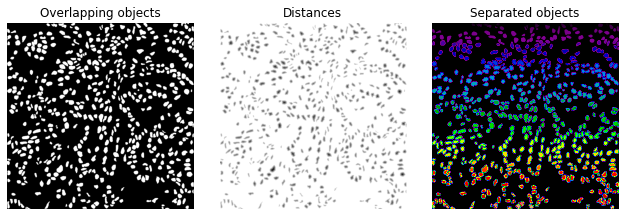

In [28]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(m)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=m)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=m)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(m, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [30]:
np.unique(labels)

array([   0,    1,    2, ..., 1658, 1659, 1660], dtype=int32)